
# Binary Image Segmentation (Beginner)
| Covering a segmentation task that identifies the background/foreground from portrait images.

In [ ]:
#| hide
!pip install wwf
!pip install nbdev

In [ ]:
# | hide
from wwf.utils import *
from nbdev import show_doc
state_versions(['fastai', 'fastcore','nbdev'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, and `nbdev` currently running at the time of writing this:
* `fastai` : 2.7.10 
* `fastcore` : 1.5.27 
* `nbdev` : 2.3.7 
---

## Introduction
This tutorial covers binary image segmentation with fastai. It is my self-assigned `homework` following [Practical Deep Learning for Coders 2022](https://course.fast.ai/) [lesson 1](https://course.fast.ai/Lessons/lesson1.html).

## Importing the Library and checking the dataset

In [ ]:
from fastai.vision.all import *
assert torch.cuda.is_available()

The dataset chosen for the task was the [AISegment.com Matting Human Datasets](https://www.kaggle.com/datasets/laurentmih/aisegmentcom-matting-human-datasets) due to its availability at Kaggle. I downloaded locally with Kaggle cli.

In [ ]:
path = Path("/run/media/fredguth/datasets/binary-image-segmentation")

In [ ]:
!ls $path

aisegmentcom-matting-human-datasets.zip  clip_img  matting  matting_human_half


The `path` contains a folder for the input image (`clip_img`) and another for the mattings (`matting`). Inside this folders, there are other folders and finally a file.  The leaf file in the `clip_img` subfolder has a correspondent one in the `matting` folder.  

As fastai `get_image_file` does not guarantee the order, we will need to sort them to garantee the correspondence.

In [ ]:
mattings = get_image_files(path/'matting').sorted()
images = get_image_files(path/'clip_img').sorted()
len(images)

34426

The dataset consist of `34426` images and their correspondent mattings. 


#### Opening image files


`fastai` uses `Pillow` to create images:


<AxesSubplot: >

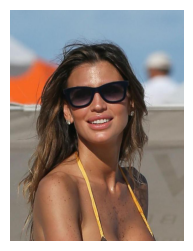

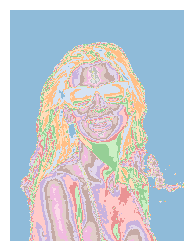

In [ ]:
img = PILImage.create(images[144])
mat = PILMask.create(mattings[144])
img.show(figsize=(3,3))
mat.show(figsize=(3,3))


Now, we will create a function to return a mask of codes, in the way MaskBlock expects.


<AxesSubplot: >

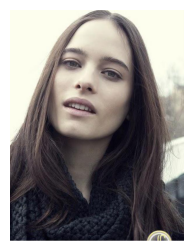

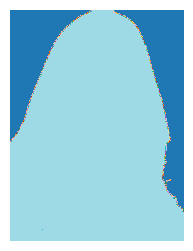

In [ ]:
codes = np.array(['bg', 'fg'])

def get_msk(fn):
    p = Path(str(fn).replace('clip', 'matting').replace('matting_img', 'matting').replace('.jpg', '.png'))
    msk = (tensor(PILImageBW.create(p))>0)*1
    msk = msk.to(torch.uint8)
    return PILMask.create(msk)
f = images[4]
m = get_msk(f)
PILImage.create(f).show(figsize=(3,3))
PILMask.create(m).show(figsize=(3,3), alpha=1)


Now that we know the expected `input` and `output` of our model, let's build it!

## Training our model
To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:


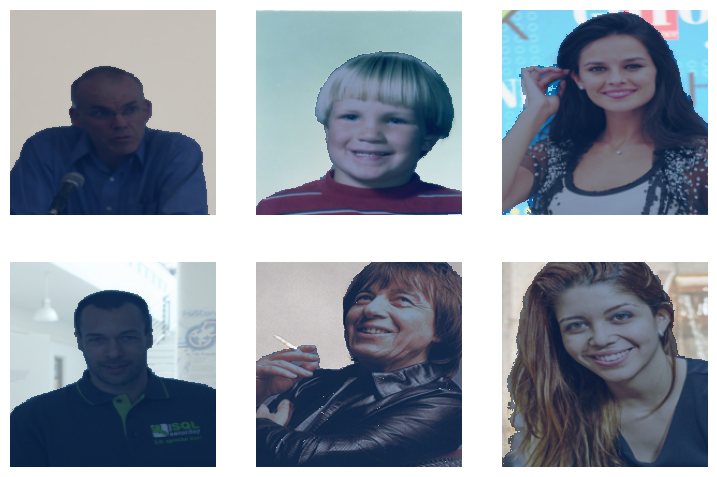

In [ ]:
dls = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   get_y=get_msk,
                   item_tfms=[Resize(192, method='squish')],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]).dataloaders(path/'clip_img', bs=8)
dls.vocabs = codes
name2id = {v:k for k,v in enumerate(codes)}
dls.show_batch(cmap='Blues', vmin=0, vmax=1, max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, MaskBlock),

The inputs to our model are images, and the outputs are Masks (a tensor of label codes).

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=get_mask,

The labels (`y` values) is obtained from the input filename by running the function `get_mask`.

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
Apply this list of transforms to each batch.  In this case, Normalize uses statistics from the imagenet dataset to normalize the data using imagenet as the sample. Normalization will try to distinguish values as much as possible, taking into account their occurrences in the sample.


In [ ]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(3)


/home/fredguth/Downloads/.anaconda3/envs/py39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/fredguth/Downloads/.anaconda3/envs/py39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,time
0,0.082208,0.065039,19:28


epoch,train_loss,valid_loss,time
0,0.058268,0.059941,22:25
1,0.040470,0.057517,20:34
2,0.055856,0.054101,18:39


Now, we can export the model for later use:


In [ ]:
learn.export('bImgSeg.pkl')

Let's see the results of this model:

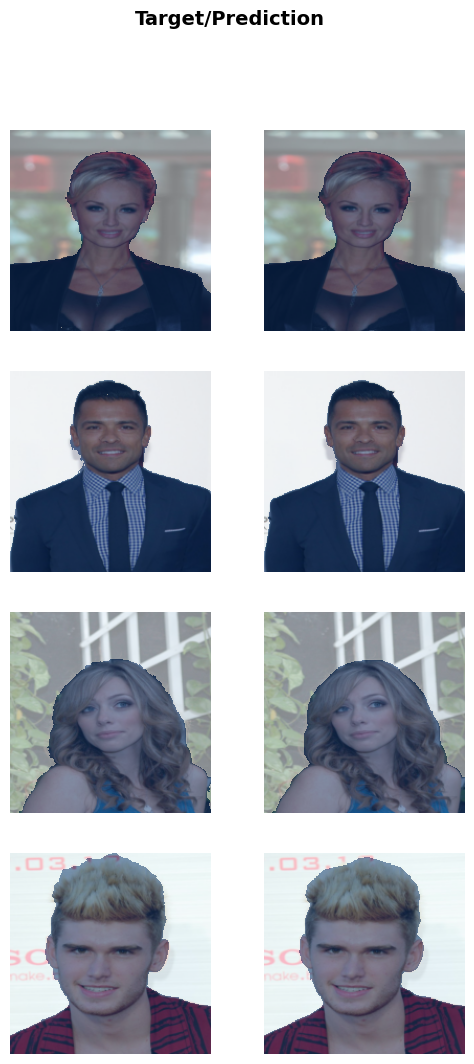

In [ ]:
learn.show_results(cmap='Blues', vmin=0, vmax=1, max_n=4)